13.92, 4.66, 67.37, 
22.35, 2.58, 63.26, 
12.50, 5.74, 74.98, 


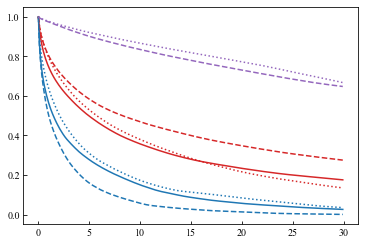

In [217]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from glob import glob

pre_pbe = "../exp/prod-adam-run2/analyses/cp2k"
pre_hicut = "../preview/analyses/nvt-hicut/cp2k/"
pre_scan = "../preview/analyses/nvt-scan/cp2k/"

    
for pre, ls in zip([pre_pbe, pre_hicut, pre_scan], ['-','--',':']):
    files = glob(f"{pre}/*-rho1.07*/persist.dat")
    t, a, b, p = np.mean([np.loadtxt(f) for f in files], axis=0).T
    print(f'{fit(t, a/a[0]):.2f}, {fit(t, b/b[0]):.2f}, {fit(t, p/p[0]):.2f}, ')
    plt.plot(t, a/a[0], color='tab:red', ls=ls)
    plt.plot(t, b/b[0], color='tab:blue', ls=ls)
    if (pre!=pre_pbe):
        plt.plot(t, p/p[0], color='tab:purple', ls=ls)
        


[(50000, 11), (50000, 11), (50000, 11)]
[(50000, 11), (50000, 11), (50000, 11)]
[(50000, 11), (50000, 11)]
[(1100, 11), (1100, 11), (1100, 11)]
[(1000, 11), (1000, 11), (1000, 11)]
[(860, 11), (860, 11), (860, 11)]


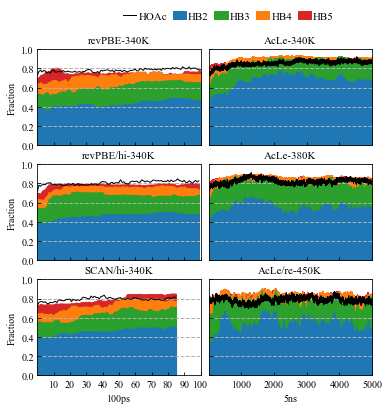

In [206]:
def draw_hb_net(ax, files, window=10):
    hbnet =  [np.loadtxt(data) for data in files]
    print([np.loadtxt(data).shape for data in files])
    hbnet = np.array(hbnet)
    t = hbnet[0,::window,0]
    molperc = hbnet[:,:,1].reshape([hbnet.shape[0],-1,window])/32.
    molperc = molperc.mean(axis=2)
    hbpop = hbnet[:,:,3:].cumsum(axis=2)/64.
    hbpop = hbpop.reshape([hbpop.shape[0],-1,window,hbpop.shape[-1]]).mean(axis=2)
    # axis: sample, time, HBSIZE
    colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:red']
    l, = ax.plot(t, molperc.mean(axis=0), 'k-', lw=1)
    handles = []
    for x, color in list(zip(hbpop.T, colors))[::-1]:
        h = ax.fill_between(t, x.mean(axis=1), color=color, alpha=1)
        handles.append(h)
    handles.append(l)
    return handles

f, axss = plt.subplots(3,2, gridspec_kw={'wspace':0.05},
                      figsize=[6,6], sharey=True)

axs = axss[:,1]

files =  glob('../exp/prod-adam-run2/analyses/prod/nvt-340*-0/*-r1.08/hbnet.dat')
handles = draw_hb_net(axs[0], files, window=10)
files =  glob('../exp/prod-adam-run2/analyses/prod/nvt-380*-0/*-r1.08/hbnet.dat')
draw_hb_net(axs[1], files, window=10)
files =  glob('../exp/transfer/analyses/prod/nvt*-0/*-r1.08/hbnet.dat')
draw_hb_net(axs[2], files, window=10)
axs[0].set_xlim(0,5000)
axs[1].set_xlim(0,5000)
axs[2].set_xlim(0,5000)

axs[0].set_title('AcLe-340K',fontsize=11)
axs[1].set_title('AcLe-380K',fontsize=11)
axs[2].set_title('AcLe/re-450K',fontsize=11)

axs[0].set_ylim(0,1)
axs[2].set_xlabel('5ns')


axs = axss[:,0]
files =  glob('../exp/prod-adam-run2/analyses/cp2k/*-rho1.0753/hbnet.dat')
handles = draw_hb_net(axs[0], files, window=10)
files =  glob('../preview/analyses/nvt-hicut/cp2k/*-rho1.0753/hbnet.dat')
draw_hb_net(axs[1], files, window=10)
files =  glob('../preview/analyses/nvt-scan/cp2k/*-rho1.0753/hbnet.dat')
draw_hb_net(axs[2], files, window=10)
axs[0].set_xlim(0,100)
axs[1].set_xlim(0,100)
axs[2].set_xlim(0,100)

axs[0].set_title('revPBE-340K',fontsize=11)
axs[1].set_title('revPBE/hi-340K',fontsize=11)
axs[2].set_title('SCAN/hi-340K',fontsize=11)
[ax.set_ylabel('Fraction') for ax in axs]
axs[0].set_ylim(0,1)
axs[2].set_xlabel('100ps')

[ax.set_xticks(np.arange(10,110,10)) for ax in axss[:,0]]
[ax.set_yticks(np.arange(0,1.01,0.2)) for ax in axss[0,:]]

[ax.set_xticks(np.arange(1000,6000,1000)) for ax in axss[:,1]]

[ax.set_xticklabels([]) for ax in axss[:2,:].flatten()]
[ax.grid(lw=1, axis='y') for ax in axss.flatten()]
axs[0].legend(handles[::-1], 
              ['HOAc']+[f'HB{i+2}' for i in range(len(handles))], 
              loc=3, bbox_to_anchor=[0.5,1.25],
              handlelength=1.2, ncol=5, fontsize=11,
              columnspacing=0.5, handletextpad=0.2, 
              borderaxespad=0)


plt.savefig('hbnet.pdf')


9.79, 3.50, 213.38, 
9.86, 2.41, 86.42, 
7.28, 2.61, 28.60, 


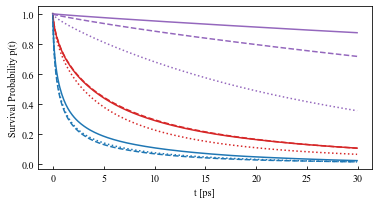

In [223]:
from scipy.optimize import curve_fit

pre_340 = "../exp/prod-adam-run2/analyses/prod/nvt-340k-5ns-0"
pre_380 = "../exp/prod-adam-run2/analyses/prod/nvt-380k-5ns-0"
pre_450 = "../exp/transfer/analyses/prod/nvt-450k-5ns-0"

plt.figure(figsize=[6,3])

def fit(t, prob):
    def f(x, A, t1, t2): 
        return A*np.exp(-x/t1)+(1-A)*np.exp(-x/t2)
    (A, t1, t2), _ = curve_fit(f, t, prob, maxfev=5000)
    return A*t1+(1-A)*t2

for pre, ls in zip([pre_340, pre_380, pre_450], ['-','--',':']):
    files = glob(f"{pre}/a16*-r1.08/persist.dat")
    t, a, b, p = np.mean([np.loadtxt(f) for f in files], axis=0).T
    print(f'{fit(t, a/a[0]):.2f}, {fit(t, b/b[0]):.2f}, {fit(t, p/p[0]):.2f}, ')
    plt.plot(t, a/a[0], color='tab:red', ls=ls)
    plt.plot(t, b/b[0], color='tab:blue', ls=ls)
    plt.plot(t, p/p[0], color='tab:purple', ls=ls)
plt.xlabel('t [ps]')
plt.ylabel('Survival Probability p(t)')

plt.savefig('p_alce.pdf')

13.92, 4.66, 67.37, 
22.35, 2.58, 63.26, 
12.50, 5.74, 74.98, 


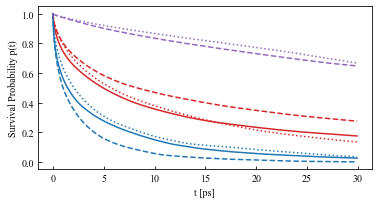

In [224]:
plt.figure(figsize=[6,3])
for pre, ls in zip([pre_pbe, pre_hicut, pre_scan], ['-','--',':']):
    files = glob(f"{pre}/*-rho1.07*/persist.dat")
    t, a, b, p = np.mean([np.loadtxt(f) for f in files], axis=0).T
    print(f'{fit(t, a/a[0]):.2f}, {fit(t, b/b[0]):.2f}, {fit(t, p/p[0]):.2f}, ')
    plt.plot(t, a/a[0], color='tab:red', ls=ls)
    plt.plot(t, b/b[0], color='tab:blue', ls=ls)
    if (pre!=pre_pbe):
        plt.plot(t, p/p[0], color='tab:purple', ls=ls)
        
plt.xlabel('t [ps]')
plt.ylabel('Survival Probability p(t)')

plt.savefig('p_dft.pdf')

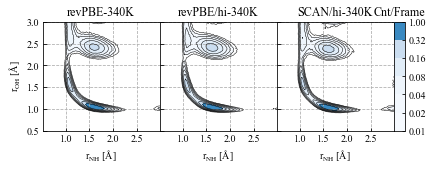

In [211]:
f, axs = plt.subplots(1,4, figsize=[6.5,2],
                      gridspec_kw={'width_ratios':[1,1,1,0.1]})
titles = ['revPBE-340K', 'revPBE/hi-340K', 'SCAN/hi-340K']
for pre, ax, title in zip([pre_pbe, pre_hicut, pre_scan], axs, titles):
    files = glob(f"{pre}/*-rho1.07*/rdf-10-110ps/NHO_rdf.dat")
    rdf = np.sum([np.loadtxt(f) for f in files], axis=0)
    levels = [0.005, 0.01,0.02,0.04,0.08,0.16,0.32, 1]
    x = np.linspace(0.5,3,100)
    ax.grid(zorder=-1)
    ax.contour(x,x,rdf.T[20:120,20:120], levels=levels, colors='k', linewidths=0.5)
    contr = ax.contourf(x,x,rdf.T[20:120,20:120], levels=levels[1:], cmap='Blues')
    ax.set_xlim(0.51,2.99)
    ax.set_xticks(np.arange(1,3,0.5))
    
    ax.set_title(title)
    ax.set_xlabel('$r_\mathrm{NH}$ [$\AA$]')
axs[0].set_ylabel('$r_\mathrm{OH}$ [$\AA$]')
axs[1].set_yticklabels([])
axs[2].set_yticklabels([])
axs[3].set_title('Cnt/Frame')
f.colorbar(contr, cax=axs[3], ticks=levels)
plt.subplots_adjust(wspace=0)
plt.savefig('dft.pdf')

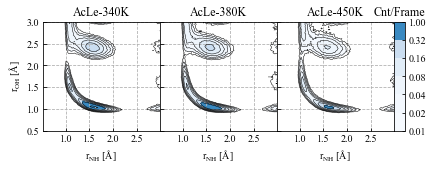

In [210]:
f, axs = plt.subplots(1,4, figsize=[6.5,2],
                      gridspec_kw={'width_ratios':[1,1,1,0.1]})
titles = ['AcLe-340K', 'AcLe-380K', 'AcLe-450K']
for pre, ax, title in zip([pre_340, pre_380, pre_450], axs, titles):
    files = glob(f"{pre}/*-r1.08/rdf-0-5ns/NHO_rdf.dat")
    rdf = np.sum([np.loadtxt(f) for f in files], axis=0)
    levels = [0.005, 0.01,0.02,0.04,0.08,0.16,0.32, 1]
    x = np.linspace(0.5,3,100)
    ax.grid(zorder=-1)
    ax.contour(x,x,rdf.T[20:120,20:120], levels=levels, colors='k', linewidths=0.5)
    contr = ax.contourf(x,x,rdf.T[20:120,20:120], levels=levels[1:], cmap='Blues')
    ax.set_xlim(0.51,2.99)
    ax.set_xticks(np.arange(1,3,0.5))
    ax.set_title(title)
    ax.set_xlabel('$r_\mathrm{NH}$ [$\AA$]')
axs[0].set_ylabel('$r_\mathrm{OH}$ [$\AA$]')
axs[1].set_yticklabels([])
axs[2].set_yticklabels([])
axs[3].set_title('Cnt/Frame')
f.colorbar(contr, cax=axs[3], ticks=levels)
plt.subplots_adjust(wspace=0)
plt.savefig('al.pdf')